# Predict the amount of renewable energy based on weather data

Datasources:

- [Load, wind and solar, prices in hourly resolution](https://data.open-power-system-data.org/time_series/2020-10-06)
- [Hourly geographically aggregated weather data for Europe](https://data.open-power-system-data.org/weather_data/2020-09-16)

In [25]:
# Get the energy dataset
import pathlib

from urllib import request

DOWNLOAD_URL = 'https://data.open-power-system-data.org/time_series/2020-10-06/time_series.sqlite'
DOWNLOAD_DIR = pathlib.Path().parent.joinpath('data/')
ENERGY_DB_PATH = DOWNLOAD_DIR.joinpath('energy_time_series.sqlite')


def fetch_energy_data():
    # Download the database file using urllib
    DOWNLOAD_DIR.mkdir(exist_ok=True)
    request.urlretrieve(DOWNLOAD_URL, ENERGY_DB_PATH)
    print('Download done.')
    


In [26]:
fetch_energy_data()

Download done.


In [51]:
import sqlite3
import pandas as pd

db_connection = sqlite3.connect(ENERGY_DB_PATH)

COLS_OF_INTEREST = ['utc_timestamp', 'DE_solar_capacity', 'DE_solar_generation_actual', 'DE_wind_capacity', 'DE_wind_generation_actual']

query = f"SELECT {','.join(COLS_OF_INTEREST)} FROM time_series_60min_singleindex"
df = pd.read_sql_query(query, db_connection)

# Manually convert utc_timestamp to datetime with the correct format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], format='ISO8601')

# Set utc_timestamp as the index (rather than the number
df.set_index('utc_timestamp', inplace=True)


In [52]:

df.info()
df.head()
df.describe()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   DE_solar_capacity           43800 non-null  float64
 1   DE_solar_generation_actual  50297 non-null  float64
 2   DE_wind_capacity            43800 non-null  float64
 3   DE_wind_generation_actual   50326 non-null  float64
dtypes: float64(4)
memory usage: 1.9 MB


,DE_solar_capacity,DE_solar_generation_actual,DE_wind_capacity,DE_wind_generation_actual
count,43800.000000,50297.000000,43800.000000,50326.000000
mean,42378.015114,4566.042905,39972.606758,11552.234650
std,4306.391773,6940.267590,7262.785787,9076.350769
min,37248.000000,0.000000,27913.000000,135.000000
25%,38810.000000,0.000000,33737.000000,4506.000000
50%,40941.000000,173.000000,39808.000000,9015.000000
75%,46092.000000,7342.000000,47730.000000,16113.750000
max,50508.000000,32947.000000,50452.000000,46064.000000


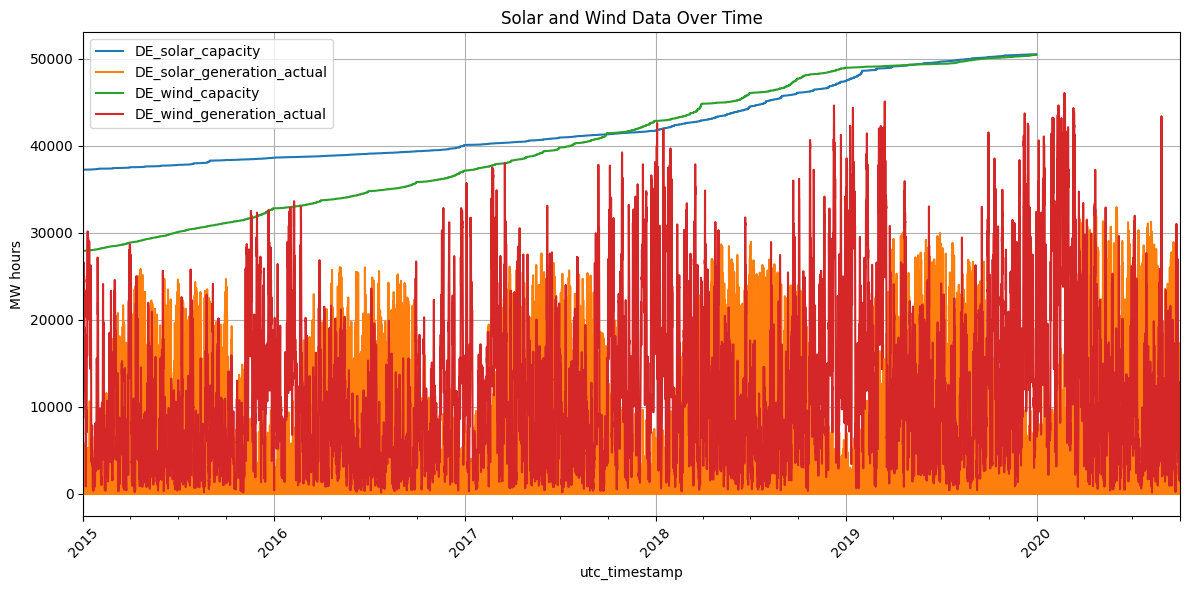

In [53]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(12, 6))

# Create a date formatter for the x-axis
date_formatter = mdates.DateFormatter('%Y')
locator = mdates.YearLocator()

ax = plt.gca()
ax.xaxis.set_major_formatter(date_formatter) ## calling the formatter for the x-axis
ax.xaxis.set_major_locator(locator) ## calling the locator for the x-axis

# Plotting
df.plot(kind='line', ax=plt.gca())
plt.title('Solar and Wind Data Over Time')
plt.ylabel('MW hours')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

